In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from scipy import integrate 
from scipy.optimize import minimize

In [2]:
with MPRester("CZceLJ3kGnm9d5zpfdqDbLaL8n671YIQ") as m:
    prim_struct = m.get_structure_by_material_id("mp-961711")
    ph_dos = m.get_phonon_dos_by_material_id("mp-961711")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Calcul des températures d'Einstein et de Debye

Einstein a supposé que chaque atome du cristal vibre autour de sa position d'équilibre à une même fréquence $\omega_{E}$. On a donc l'expression de la chaleur spécifique : $\frac{C_{v}}{3N_{at}R} = (\frac{\Theta_{E}}{T})^2\frac{e^{\frac{\Theta_E}{T}}}{(e^{\frac{\Theta_E}{T}} - 1)^2}$ avec $\Theta_E = \frac{ħ \omega_E}{k_B}$ la température d'Einstein.

Debye a effectué l'hypothèse que les fréquences propres ont la même dispersion linéaire : $\omega_{\sigma}(q) = vq$. On a donc l'expression de la chaleur spécifique : $\frac{C_v}{3N_{at}R} = 3(\frac{\Theta_D}{T})^3\int_{0}^{\frac{\Theta_D}{T}}{\frac{x^4e^x}{(e^x - 1)^2}}dx$ avec avec $\Theta_D = \frac{ħ \omega_D}{k_B}$ la température d'Einstein.

In [3]:
temperatures = np.arange(5,1000,5)
R = 8.314 
N_at = len(prim_struct) 
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))]) /(3*N_at*R)

In [4]:
def cv_Einstein(T, Te):
    return (Te/T)**2*np.exp(Te/T) / (np.exp(Te/T)-1)**2

def error_Einstein(Te):
    cv_E = cv_Einstein(temperatures, Te)  
    return np.sum((ph_cv - cv_E)**2)

Te_init = 200
Te_optimal = minimize(error_Einstein, Te_init).x[0]

print("La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de", str(Te_optimal), "K")

La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de 279.72338664790607 K


In [5]:
# Modèle de Debye
def integrande(x):
    return (x**4*np.exp(x)) / (np.exp(x)-1)**2

def cv_Debye(T, Td):
    return 3*(T/Td)**3 * integrate.quad(integrande,0,Td/T)[0]

def error_Debye(theta_D):
    return np.sum([(cv_Debye(temperatures[i], theta_D) - ph_cv[i])**2 for i in range(len(temperatures))])

Td_init = 200
Td_optimal = minimize(error_Debye, Td_init).x[0]

print("La température de Debye qui minimise l'erreur au sens des moindres carrés est de", str(Td_optimal), "K")

La température de Debye qui minimise l'erreur au sens des moindres carrés est de 378.40843440412186 K


## Représentation des courbes de chaleurs spécifiques

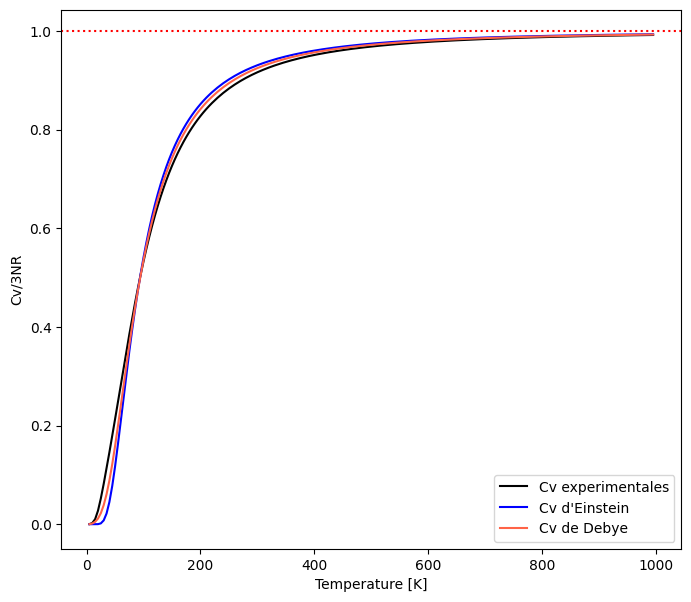

In [7]:
cv_E = cv_Einstein(temperatures, Te_optimal)
cv_D = np.array([cv_Debye(temp, Td_optimal) for temp in temperatures])

plt.figure(figsize=(8, 7))
plt.plot(temperatures, ph_cv, label="Cv experimentales", color='black')
plt.plot(temperatures, cv_E, label="Cv d'Einstein" , color='blue')
plt.plot(temperatures, cv_D, label="Cv de Debye", color='tomato')
plt.axhline(y=1, color='red', linestyle= 'dotted')
plt.xlabel('Temperature [K]')
plt.ylabel("Cv/3NR")
plt.legend()
plt.show()

## Représentation des densités d'états de phonons

In [8]:
frequencies = ph_dos.frequencies
densities = ph_dos.densities

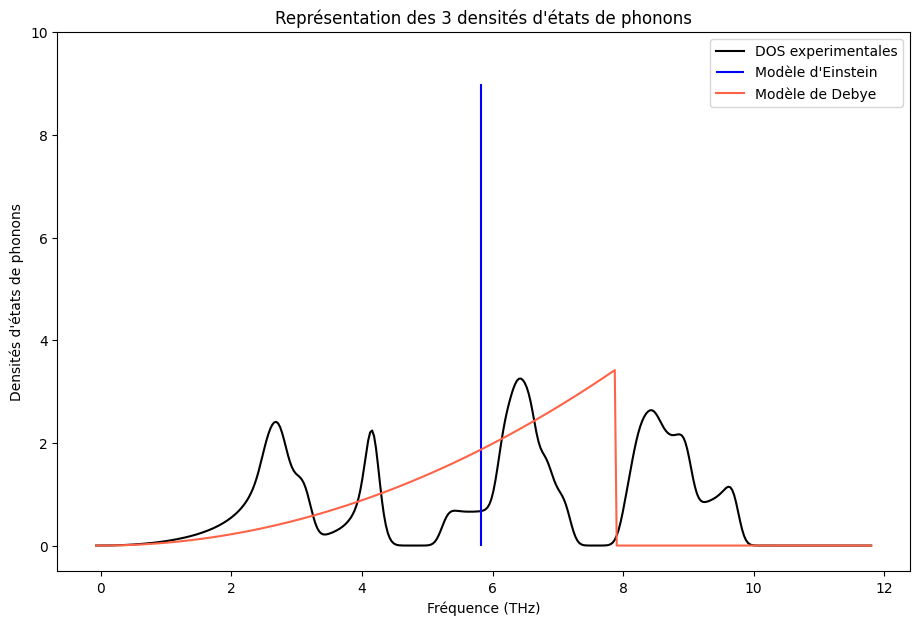

In [9]:
kB = 1.3806485e-23 
hbar = 1.055e-34 
THz = 1e-12

Theta_E = Te_optimal * kB * THz / hbar
Theta_D = Td_optimal * kB * THz / hbar  

dos_D = np.zeros(len(frequencies))
for i,f in enumerate(frequencies):
    T = 2*np.pi*f
    if T < Theta_D:
        dos_D[i] = (9*N_at*(T)**2/(Theta_D**3))

plt.figure(figsize=(11, 7))
plt.plot(frequencies, densities ,color = "black", label="DOS experimentales")
plt.vlines(Theta_E/(2*np.pi), 0, 3 * N_at ,color ="blue", label = "Modèle d'Einstein") 
plt.plot(frequencies, dos_D*(2*np.pi), color="tomato", label="Modèle de Debye")
plt.title("Représentation des 3 densités d'états de phonons")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()